In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
# cudnn.benchmark = True

In [4]:

from PIL import Image

# Function that opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0)
])


# Plots image from tensor
def tensor_imshow(inp, title=None, **kwargs):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Mean and std for ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)


# Given label number returns class name
def get_class_name(c):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    return ' '.join(labels[c].split(',')[0].split()[1:])


# Image preprocessing function
preprocess = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                # Normalization for ImageNet
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])


In [5]:
workers = 8
input_size = (224, 224)
gpu_batch = 250

In [6]:
model = models.resnet50()
# model_weights = torch.load("path to the model weight")
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
# model = model.cuda()

for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
# model = nn.DataParallel(model)

In [7]:
from skimage.transform import resize

In [8]:
class RISE(nn.Module):
    def __init__(self, model, input_size, gpu_batch=100):
        super(RISE, self).__init__()
        self.model = model
        self.input_size = input_size
        self.gpu_batch = gpu_batch

    def generate_masks(self, N, s, p1, savepath='masks.npy'):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            # Random shifts
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            # Linear upsampling and cropping
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float()
        # self.masks = self.masks.cuda()
        self.N = N
        self.p1 = p1

    def forward(self, x):
        N = self.N
        _, _, H, W = x.size()
        # Apply array of filters to the image
        stack = torch.mul(self.masks, x.data)

        # p = nn.Softmax(dim=1)(model(stack)) processed in batches
        p = []
        for i in range(0, N, self.gpu_batch):
            p.append(self.model(stack[i:min(i + self.gpu_batch, N)]))
        p = torch.cat(p)
        # Number of classes
        CL = p.size(1)
        sal = torch.matmul(p.data.transpose(0, 1), self.masks.view(N, H * W))
        sal = sal.view((CL, H, W))
        sal = sal / N / self.p1
        return sal

In [9]:
explainer = RISE(model, input_size, gpu_batch)

In [10]:
# Generate masks for RISE or use the saved ones.
maskspath = 'masks.npy'
explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=maskspath)

Generating filters: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:16<00:00, 365.37it/s]


In [16]:
def sal_map(img, top_k=1):
    saliency = explainer(img).cpu().numpy()
    p, c = torch.topk(model(img), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k], get_class_name(c[k])))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(get_class_name(c[k]))
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)

    plt.show()

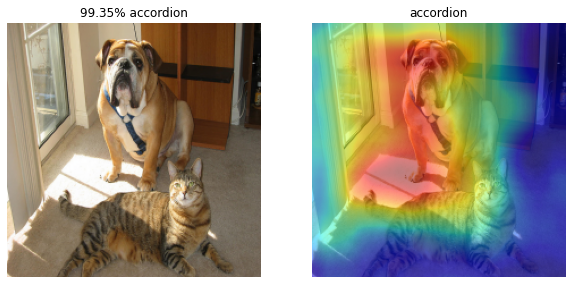

In [18]:
sal_map(read_tensor('catdog.png'))